<a href="https://colab.research.google.com/github/jjkiljanski/biebrza-shrub-encroachment-analysis/blob/main/gee_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q earthengine-api geemap

import ee
import geemap

# Log in to your Google account for Earth Engine (you will see a link)
ee.Authenticate()

# Start Earth Engine
ee.Initialize(project='biebrza-encroachment-analysis')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


# Load Resources

In [17]:
import ipywidgets as widgets
from datetime import datetime

# ============================================================
# Load Biebrzański National Park boundary
#    (from the WDPA – World Database on Protected Areas)
# ============================================================

wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

# Filter areas whose NAME contains "Biebrza" (safe way to match spelling)
bpn = wdpa.filter(ee.Filter.stringContains("NAME", "Biebrza"))

print("Number of matching park polygons:", bpn.size().getInfo())

# Geometry for clipping satellite images
region_geom = bpn.geometry()


Number of matching park polygons: 3


In [18]:
# ============================================================
# Load a shapefile defining 1997-2015 MPC change categories
#    derived from Kopeć and Sławik (2020)
# ============================================================

# FeatureCollection with ALL shrunk squares
mpc_all = ee.FeatureCollection(
    "projects/biebrza-encroachment-analysis/assets/MPC_all_traj_simple_97_15_shrunk25m"
)

# Name of the category column in the shapefile
category_prop = "traj_simpl"

# Get the list of unique categories from the shapefile (server-side)
categories = ee.List(mpc_all.aggregate_array(category_prop).distinct().sort())

# Bring list to client for looping / printing
category_list = categories.getInfo()
print("Categories found in shapefile:", category_list)

# --- DROP empty string categories ---
category_list = [c for c in category_list if c not in ("", None)]
print("Categories after removing empty / None:", category_list)

# Optional: build a dict of FeatureCollections keyed by category
mpc_fc = {
    cat: mpc_all.filter(ee.Filter.eq(category_prop, cat))
    for cat in category_list
}

# Example: use one category (if present)
# e.g. first category in the list
if category_list:
    example_cat = category_list[0]
    example_fc = mpc_fc[example_cat]
    print("Example category:", example_cat)
else:
    example_fc = None
    print("No categories found in shapefile.")

Categories found in shapefile: ['', 'shrubs_to_trees', 'stable_shrubs', 'stable_trees', 'stable_wetland', 'wetland_to_shrubs', 'wetland_to_trees']
Categories after removing empty / None: ['shrubs_to_trees', 'stable_shrubs', 'stable_trees', 'stable_wetland', 'wetland_to_shrubs', 'wetland_to_trees']
Example category: shrubs_to_trees


In [19]:
# ============================================================
# Load shapefiles defining 1997-2015 MPC change categories
#    derived from Kopeć and Sławik (2020)
# ============================================================
cat_names = [
    "shrubs_to_trees",
    "stable_shrubs",
    "stable_trees",
    "stable_wetland",
    "wetland_to_shrubs",
    "wetland_to_trees"
]

# Load each shapefile as a FeatureCollection
mpc_fc = {
    cat: ee.FeatureCollection(
        f"projects/biebrza-encroachment-analysis/assets/MPC_{cat}"
    )
    for cat in cat_names
}

# Example: use one category
stable_wetland_fc = mpc_fc["stable_wetland"]

# Prepare the photo sequence

In [20]:
def get_landsat_l2_sr():
    lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')  # do 2011
    le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')  # 1999–dzisiaj (SLC-off od 2003)
    lc8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')  # od 2013
    lc9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')  # od ~2021

    return lt5.merge(le7).merge(lc8).merge(lc9)

landsat = get_landsat_l2_sr()

In [21]:
# ================================================================
# Mask function for Landsat Collection 2 Level 2 Surface Reflectance
# ================================================================

def mask_l2_sr(image):
    """
    Applies the official USGS cloud/shadow/snow/saturation masks
    for Landsat Collection 2 Level-2 Surface Reflectance products.

    QA_PIXEL bits:
      Bit 0: Fill
      Bit 1: Dilated Cloud
      Bit 2: Cirrus
      Bit 3: Cloud
      Bit 4: Cloud Shadow

    QA_RADSAT:
      Indicates radiometric saturation in any band (values > 0 should be masked)
    """
    qa = image.select('QA_PIXEL')
    radsat = image.select('QA_RADSAT')

    # Bits 0–4 all must be zero (no fill, no clouds, no cirrus, no shadow)
    cloud_bits = int('11111', 2)
    qa_mask = qa.bitwiseAnd(cloud_bits).eq(0)

    # Radiometric saturation mask (value must be zero)
    sat_mask = radsat.eq(0)

    return image.updateMask(qa_mask).updateMask(sat_mask)

In [22]:
# =======================================================================
# Function to add NDMI, NBR and keep NIR as an index band for each image
# =======================================================================

def add_indices(image):
    # Work in float to avoid integer division issues
    image = image.toFloat()

    nir   = image.select('NIR')
    red   = image.select('RED')
    swir1 = image.select('SWIR1')
    swir2 = image.select('SWIR2')

    # NDVI = (NIR - RED) / (NIR + RED)
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # NDMI = (NIR - SWIR1) / (NIR + SWIR1)
    ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')

    # NBR = (NIR - SWIR2) / (NIR + SWIR2)
    nbr = nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')

    # Add the index bands to each image
    return image.addBands([ndvi, ndmi, nbr])

In [23]:
# ================================================================
# Correct band mapping for Landsat 5/7 (TM / ETM+)
# ================================================================

def prep_ls57(image):
    """
    Prepares Landsat 5 (TM) and Landsat 7 (ETM+) Level-2 SR images.

    Landsat 5/7 Surface Reflectance band names:
      SR_B1 = Blue
      SR_B2 = Green
      SR_B3 = Red
      SR_B4 = Near Infrared (NIR)
      SR_B5 = SWIR1
      SR_B7 = SWIR2
    """
    image = mask_l2_sr(image)

    # Rename bands to a unified spectral scheme (BLUE, GREEN, RED, NIR)
    return image.select(
        ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
        ['BLUE',  'GREEN', 'RED',  'NIR', 'SWIR1', 'SWIR2']
    )


# ================================================================
# Correct band mapping for Landsat 8/9 (OLI / OLI-2)
# ================================================================

def prep_ls89(image):
    """
    Prepares Landsat 8 and Landsat 9 Level-2 SR images.

    Landsat 8/9 Surface Reflectance band names:
      SR_B2 = Blue
      SR_B3 = Green
      SR_B4 = Red
      SR_B5 = Near Infrared (NIR)
      SR_B6 = SWIR1
      SR_B7 = SWIR2

    IMPORTANT:
      This mapping is DIFFERENT from Landsat 5/7!
      That’s why we cannot "guess" the mapping — we must explicitly map by sensor.
    """
    image = mask_l2_sr(image)

    return image.select(
        ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
        ['BLUE',  'GREEN', 'RED',  'NIR', 'SWIR1', 'SWIR2']
    )


# ================================================================
# Build a single harmonized image collection combining L5/7/8/9
# ================================================================

# Landsat TM (5)  → use prep_ls57
lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').map(prep_ls57)

# Landsat ETM+ (7) → use prep_ls57
le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').map(prep_ls57)

# Landsat OLI (8)  → use prep_ls89
lc8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').map(prep_ls89)

# Landsat OLI-2 (9) → use prep_ls89
lc9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').map(prep_ls89)

# Unified L5+L7+L8+L9 collection with consistent band names
landsat = lt5.merge(le7).merge(lc8).merge(lc9)

# Add NDMI & NBR to each image, and keep only NDMI, NBR, NIR for analysis
landsat = (landsat
           .map(add_indices)
           .select(['NDMI', 'NBR', 'NIR', 'NDVI', 'SWIR1', 'SWIR2']))

In [24]:
#-------------------------------------------------
# annual composite with per-pixel obs_count
#   + per-year quality summary properties
# -------------------------------------------------

def annual_composite(year, geom, scale=30):
    """
    Build an annual median composite (May–Sep) and attach:
      - 'obs_count' band: number of valid observations per pixel
      - properties summarizing obs_count (mean, std, min, max)
      - property 'obs_hist': histogram of obs_count over geom
      - property 'image_count': number of images in the collection
    """
    year = int(year)
    start = ee.Date.fromYMD(year, 5, 1)
    end   = ee.Date.fromYMD(year, 9, 30)

    col = (landsat
           .filterBounds(geom)
           .filterDate(start, end))

    # Number of images in the collection for this year (anywhere in geom)
    image_count = col.size()

    # Per-pixel count of valid (unmasked) observations
    # Use any band (e.g. NIR) as they are all masked consistently.
    obs_count = col.select('NIR').count().rename('obs_count')

    # Median composite of reflectance bands
    median_img = col.median()

    # Combine reflectance + obs_count
    img = median_img.addBands(obs_count).clip(geom)

    # Global stats of obs_count over the geometry
    # (mean, stdDev, min, max) – good quick QC indicators.
    obs_stats = obs_count.reduceRegion(
        reducer=ee.Reducer.mean()\
                    .combine(ee.Reducer.stdDev(), sharedInputs=True)\
                    .combine(ee.Reducer.minMax(), sharedInputs=True),
        geometry=geom,
        scale=scale,
        maxPixels=1e12
    )

    # Attach metadata as image properties
    img = img.set({
        'year': year,
        'image_count': image_count,
        'obs_mean':  obs_stats.get('obs_count_mean'),
        'obs_std':   obs_stats.get('obs_count_stdDev'),
        'obs_min':   obs_stats.get('obs_count_min'),
        'obs_max':   obs_stats.get('obs_count_max'),
    })

    return img

In [ ]:
years = [1997,2015]#list(range(1997, 2026))
for y in years:
    img = annual_composite(y, region_geom)

    year        = img.get('year').getInfo()
    image_count = img.get('image_count').getInfo()
    obs_mean    = img.get('obs_mean').getInfo()
    obs_std     = img.get('obs_std').getInfo()
    obs_min     = img.get('obs_min').getInfo()
    obs_max     = img.get('obs_max').getInfo()

    print(f"\nYear {year}")
    print(f"  Images in collection       : {image_count}")
    print(f"  obs_count mean             : {obs_mean:.2f}")
    print(f"  obs_count std              : {obs_std:.2f}")
    print(f"  obs_count min / max        : {obs_min} / {obs_max}")

In [25]:
# -------------------------------------------------
# Biannual composite: (year, year+1), May–Sep only
#   e.g. 1997-1998, 1999-2000, ...
# -------------------------------------------------

def biannual_composite(start_year, geom, scale=30):
    """
    Build a 2-year median composite (May–Sep of start_year and start_year+1)
    and attach per-pixel obs_count + some QC properties.
    """
    start_year = int(start_year)
    end_year = start_year + 1

    # Filter to those two calendar years and vegetation season months
    col = (landsat
           .filterBounds(geom)
           .filter(ee.Filter.calendarRange(start_year, end_year, 'year'))
           .filter(ee.Filter.calendarRange(5, 9, 'month')))

    image_count = col.size()

    # Per-pixel count of valid obs (use NIR as reference)
    obs_count = col.select('NIR').count().rename('obs_count')

    # Median composite for NDMI, NBR, NIR, NDVI, SWIR1, SWIR2
    median_img = col.median()

    img = median_img.addBands(obs_count).clip(geom)

    # QC stats of obs_count over the geometry
    obs_stats = obs_count.reduceRegion(
        reducer=(ee.Reducer.mean()
                 .combine(ee.Reducer.stdDev(), sharedInputs=True)
                 .combine(ee.Reducer.minMax(), sharedInputs=True)),
        geometry=geom,
        scale=scale,
        maxPixels=1e12
    )

    label = f'{start_year}_{end_year}'

    img = img.set({
        'start_year': start_year,
        'end_year': end_year,
        'label': label,
        'image_count': image_count,
        'obs_mean':  obs_stats.get('obs_count_mean'),
        'obs_std':   obs_stats.get('obs_count_stdDev'),
        'obs_min':   obs_stats.get('obs_count_min'),
        'obs_max':   obs_stats.get('obs_count_max'),
    })

    return img

In [26]:
# ---------------------------------------------------------------------
# 1. Export one image per 2-year window (1997–1998, 1999–2000, ...)
# ---------------------------------------------------------------------

# Folder/prefix for all the photos
ASSET_PREFIX = 'projects/biebrza-encroachment-analysis/assets/image_composites/biannual_'

# Start years for 2-year windows: 1997-1998, 1999-2000, ...
biannual_start_years = list(range(1997, 2025, 2))

# Evaluate image per image to split computation into small tasks
for y in biannual_start_years:
    label = f'{y}_{y+1}'

    # Your existing composite function
    img = biannual_composite(y, region_geom)

    # Keep only index bands (same as you used for the stack later)
    img = img.select(['NDMI', 'NBR', 'NIR', 'NDVI', 'SWIR1', 'SWIR2'])

    # Build assetId and description
    asset_id = f'{ASSET_PREFIX}{label}'
    description = f'biannual_{label}'

    task = ee.batch.Export.image.toAsset(
        image=img,
        description=description,
        assetId=asset_id,
        region=region_geom,
        scale=10,         # <- set to your preferred resolution
        maxPixels=1e13    # <- adjust if needed
    )

    print(f'Starting export for {label} -> {asset_id}')
    task.start()

print('Started export tasks for all biannual composites.')


Starting export for 1997_1998 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_1997_1998
Starting export for 1999_2000 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_1999_2000
Starting export for 2001_2002 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2001_2002
Starting export for 2003_2004 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2003_2004
Starting export for 2005_2006 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2005_2006
Starting export for 2007_2008 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2007_2008
Starting export for 2009_2010 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2009_2010
Starting export for 2011_2012 -> projects/biebrza-encroachment-analysis/assets/image_composites/biannual_2011_2012
Starting export for 2013_2014 -> projects/biebrza-encroachment-analysis/assets/i

In [ ]:
# List of asset IDs
asset_ids = [f'{ASSET_PREFIX}{y}_{y+1}' for y in biannual_start_years]

# List of ee.Image objects
biannual_images = [ee.Image(asset_id) for asset_id in asset_ids]

print('Number of loaded images:', len(biannual_images))

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_biannual_obs_stats(biannual_images):
    """
    biannual_images: list of ee.Image, already loaded from assets.
    Each image is assumed to have properties:
        start_year, end_year, label,
        obs_mean, obs_std, obs_min, obs_max
    as set in biannual_composite().
    """
    stats = []

    for img in biannual_images:
        # Pull relevant properties from the image (server → client)
        props = img.toDictionary([
            'start_year',
            'end_year',
            'label',
            'obs_mean',
            'obs_std',
            'obs_min',
            'obs_max'
        ]).getInfo()

        stats.append({
            'start_year': props['start_year'],
            'end_year':   props['end_year'],
            'label':      props['label'],
            'obs_mean':   props['obs_mean'],
            'obs_std':    props['obs_std'],
            'obs_min':    props['obs_min'],
            'obs_max':    props['obs_max'],
        })

    # Make a DataFrame and sort by start_year, just in case
    df = pd.DataFrame(stats).sort_values('start_year')

    # X and Y for plotting
    x = df['start_year']
    y_mean = df['obs_mean']
    y_std = df['obs_std']
    y_min = df['obs_min']
    y_max = df['obs_max']

    plt.figure(figsize=(10, 5))

    # Mean with error bars = ±1 std dev
    plt.errorbar(
        x,
        y_mean,
        yerr=y_std,
        fmt='o-',
        capsize=4,
        label='Mean ± 1 std'
    )

    # Min–max shaded band
    plt.fill_between(
        x,
        y_min,
        y_max,
        alpha=0.2,
        label='Min–max'
    )

    plt.xlabel('Biannual start year')
    plt.ylabel('obs_count (per pixel)')
    plt.title('Biannual obs_count statistics over region')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df  # return the table too, in case you want it

In [28]:
def load_exported_biannual_assets(asset_folder_prefix):
    """
    asset_folder_prefix: string
        Example: 'projects/biebrza-encroachment-analysis/assets/image_composites/'

    Returns:
        list of ee.Image for all assets currently present under that path.
    """

    # Query Earth Engine for all assets under this folder
    listing = ee.data.listAssets({'parent': asset_folder_prefix})

    # listing['assets'] is a list of dicts, each with 'name', 'type', etc.
    images = []
    for a in listing.get('assets', []):
        if a['type'] == 'IMAGE':
            images.append(ee.Image(a['name']))   # 'name' is the full asset ID

    return images

In [40]:
ASSET_FOLDER = 'projects/biebrza-encroachment-analysis/assets/image_composites'

biannual_images = load_exported_biannual_assets(ASSET_FOLDER)

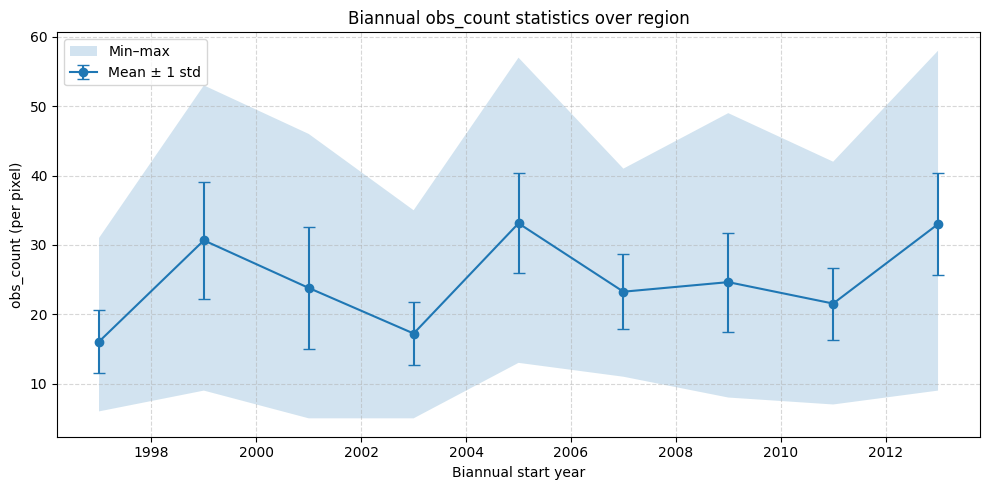

In [41]:
# Plot stats of the image series
df_stats = plot_biannual_obs_stats(biannual_images)

In [ ]:
# Run this cell to export a chosen biannual composite
year = 2009
img = biannual_composite(year, region_geom)
# img = annual_composite(year, region_geom)

export_image = img.select(['NDMI', 'NBR', 'NIR']).float()

task = ee.batch.Export.image.toDrive(
    image=export_image,
    description=f'biebrza_{year}_biannual_ndmi_nbr_nir',
    folder='GEE_Biebrza',
    fileNamePrefix=f'biebrza_{year}_biannual_ndmi_nbr_nir',
    scale=30,
    region=region_geom,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
task.start()

# Create pixel series

In [34]:
# -----------------------------------------------
# Set a projection from 30 m Landsat projection
# -----------------------------------------------

# 'region_geom' must be defined earlier in your script
ref_img = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(region_geom) \
    .first()

# Use NIR band as reference (could be any band)
ref_proj = ref_img.select('SR_B5').projection()
pixel_scale = ref_proj.nominalScale()

In [ ]:
# ============================================================
# Compute the number of Landsat pixels falling into each category
# ============================================================

print('Reference nominal scale (m):', pixel_scale.getInfo())

# -----------------------------------------------
# Choose an annual composite and band
# -----------------------------------------------

year_for_count = 2015  # change as you like

# Your existing function to build annual composite
annual_img = annual_composite(year_for_count, region_geom)

# Pick a band to define the pixel grid (e.g. NIR)
band_name = 'NIR'

# Reproject the composite band to the reference 30 m grid
band_img = annual_img.select(band_name).reproject(ref_proj)

# -----------------------------------------------
# Function: count pixels in each FC
#   (centroids inside polygons)
# -----------------------------------------------

def count_pixels_in_fc(image, fc, scale):
    """
    Counts unmasked pixels of `image` whose CENTROIDS
    fall inside each feature of `fc`.

    Returns the total count across all features.
    """
    counted_fc = image.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.count(),
        scale=scale
        # Default behavior: pixel counted if centroid is inside geometry
    )

    # Sum 'count' over all features in this FC
    total = counted_fc.aggregate_sum('count')
    return total

# -----------------------------------------------
# Loop over categories (from shapefile column)
# -----------------------------------------------

results = {}

for cat in category_list:
    fc_cat = mpc_fc[cat]  # filtered FeatureCollection for this category
    total_pixels = count_pixels_in_fc(band_img, fc_cat, pixel_scale).getInfo()
    results[cat] = total_pixels
    print(f"{cat}: {total_pixels} pixels (centroids inside polygons)")

# `results` now holds pixel counts for all categories found in the shapefile

Reference nominal scale (m): 30
shrubs_to_trees: 7724 pixels (centroids inside polygons)
stable_shrubs: 48565 pixels (centroids inside polygons)
stable_trees: 85587 pixels (centroids inside polygons)
stable_wetland: 122565 pixels (centroids inside polygons)
wetland_to_shrubs: 2685 pixels (centroids inside polygons)
wetland_to_trees: 284 pixels (centroids inside polygons)


### Stack all biannual NDMI/NBR/NIR into one multi-band image

In [35]:
# -------------------------------------------------
# Build a multi-band image with all 2-year NDMI/NBR/NIR
# Bands will be like: NDMI_1997_1998, NBR_1997_1998, NIR_1997_1998, ...
# -------------------------------------------------

biannual_bands = []

# Use the ALREADY-EXPORTED images loaded into biannual_images
for y, img in zip(biannual_start_years, biannual_images):
    label = f'{y}_{y+1}'
    # Keep only index bands for time series
    bands = img.select(['NDMI', 'NBR', 'NIR', 'NDVI', 'SWIR1', 'SWIR2'])
    renamed = bands.rename([
        f'NDMI_{label}',
        f'NBR_{label}',
        f'NIR_{label}',
        f'NDVI_{label}',
        f'SWIR1_{label}',
        f'SWIR2_{label}'
    ])
    biannual_bands.append(renamed)

# One big image with all time steps stacked along the band dimension
time_series_img = ee.Image.cat(biannual_bands)

### Encode category + square ID as rasters

In [36]:
# --------------------------------------------
# 1) Filter MPC features to valid categories
#    (category_list already excludes "" and None)
# --------------------------------------------

# category_prop was set earlier, e.g.:
# category_prop = "traj_simpl"

mpc_all_clean = mpc_all.filter(
    ee.Filter.inList(category_prop, category_list)
)

# --------------------------------------------
# 2) Create numeric category IDs (string -> int)
# --------------------------------------------

cat_to_id_py = {cat: i for i, cat in enumerate(category_list)}
cat_lookup = ee.Dictionary(cat_to_id_py)

def add_cat_id(feat):
    cat = feat.get(category_prop)
    return feat.set('cat_id', cat_lookup.get(cat))

mpc_all_with_id = mpc_all_clean.map(add_cat_id)

# --------------------------------------------
# 3) Choose the square-id property (kept as STRING)
#    We will NOT rasterize it; we'll copy it with sampleRegions
# --------------------------------------------

square_id_prop = 'numark'   # column name in MPC_all
# (no reduceToImage here anymore)

### Create a stable pixel ID (row/col based)

In [37]:
# -------------------------------------------------
# Pixel ID from row/col in the Landsat grid
# -------------------------------------------------

# Pixel coordinates in the Landsat projection
coords = ee.Image.pixelCoordinates(ref_proj)  # bands: 'x', 'y' in your case

x = coords.select('x')
y = coords.select('y')

# Build a unique numeric pixel id from x,y
# (we convert to int to avoid float weirdness)
x_int = x.toInt64()
y_int = y.toInt64()

pixel_id_img = x_int.multiply(1000000000).add(y_int).rename('pixel_id')


### Combine everything and sample only MPC pixels



In [ ]:
# -------------------------------------------------
# Combine time series bands + meta bands + training tags
# -------------------------------------------------

# Start with time-series bands + pixel_id
full_img = time_series_img.addBands(pixel_id_img)

# Rasterize cat_id from mpc_all_with_id:
# pixels covered by MPC polygons get their cat_id value,
# other pixels are masked (no category).
cat_id_img = mpc_all_with_id.reduceToImage(
    properties=['cat_id'],
    reducer=ee.Reducer.first()
).rename('cat_id')

# Training mask: 1 where cat_id is defined, 0 elsewhere
train_mask = cat_id_img.mask().rename('train_mask')

# Add these bands to the full image
full_img = full_img.addBands([cat_id_img, train_mask])

print('Full image bands:', full_img.bandNames().getInfo())

Number of pixel time-series: 142327


### Sanity checks

In [ ]:
# --------------------------------------------
# Show 3 example time-series for a given category
# --------------------------------------------

target_category = "wetland_to_shrubs"   # << change to desired category

subset = samples_all.filter(
    ee.Filter.eq(category_prop, target_category)
).limit(3)

example_feats = subset.getInfo()['features']

for i, f in enumerate(example_feats):
    print(f"\n=== Feature {i} (category: {target_category}) ===")
    props = f['properties']

    # Metadata
    print("cat_id  :", props.get('cat_id'))
    print("numark  :", props.get('numark'))
    print("pixel_id:", props.get('pixel_id'))

    # Time-series values
    print("\nTime-series (NDMI / NBR / NIR):")
    for k in sorted(props.keys()):
        if (k.startswith('NDMI_') or
            k.startswith('NBR_') or
            k.startswith('NIR_')):
            print(f"  {k}: {props[k]}")


=== Feature 0 (category: wetland_to_shrubs) ===
cat_id  : 4
numark  : FQ24
pixel_id: -38999997070

Time-series (NDMI / NBR / NIR):
  NBR_1997_1998: 0.27881699800491333
  NBR_1999_2000: 0.2772473394870758
  NBR_2001_2002: 0.3239765763282776
  NBR_2003_2004: 0.3107593357563019
  NBR_2005_2006: 0.33042189478874207
  NBR_2007_2008: 0.3013037443161011
  NBR_2009_2010: 0.32232844829559326
  NBR_2011_2012: 0.3285122215747833
  NBR_2013_2014: 0.34001994132995605
  NBR_2015_2016: 0.34679272770881653
  NDMI_1997_1998: 0.1247209757566452
  NDMI_1999_2000: 0.11621225625276566
  NDMI_2001_2002: 0.16712918877601624
  NDMI_2003_2004: 0.16059160232543945
  NDMI_2005_2006: 0.17216724157333374
  NDMI_2007_2008: 0.14285017549991608
  NDMI_2009_2010: 0.1705288141965866
  NDMI_2011_2012: 0.1617019921541214
  NDMI_2013_2014: 0.18797312676906586
  NDMI_2015_2016: 0.18873700499534607
  NIR_1997_1998: 19039
  NIR_1999_2000: 19702
  NIR_2001_2002: 20180.5
  NIR_2003_2004: 20249
  NIR_2005_2006: 20716.5
  NIR_2

### Save time-series as a GEE asset

In [ ]:
# -------------------------------------------------
# Export full tagged time-series image for later sampling
# -------------------------------------------------

task = ee.batch.Export.image.toAsset(
    image=full_img,
    description='biebrza_biannual_pixel_series_tagged',
    assetId='projects/biebrza-encroachment-analysis/assets/image_composites/biebrza_biannual_pixel_series_tagged',
    region=region_geom,
    scale=pixel_scale,
    maxPixels=1e13
)
task.start()